In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from LB_D2Q9.dimensionless import opencl_dim as lb_cl

# Playing with visualization simulations

We create simulations at different resolutions with the same Reynold's number.

In [3]:
D = 10.5 # meter
rho = 10. # kg/m^3
nu = 5. # Viscosity, m^2/s

pressure_grad = -100 # Pa/m

pipe_length = 2*D # meter

sim = lb_cl.Pipe_Flow(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
                       N=400, time_prefactor=1,
                       two_d_local_size = (32, 32), three_d_local_size = (32, 32, 1))

Characteristic L: 10.5
Characteristic T: 1.0246950766
Weinstein number: 21.5185966085
u_lb: 0.0025
omega 1.5639312509
2d global: (832, 416)
2d local: (32, 32)
3d global: (832, 416, 9)
3d local: (32, 32, 1)
The platforms detected are:
---------------------------
NVIDIA CUDA NVIDIA Corporation version: OpenCL 1.2 CUDA 7.5.23
The devices detected on platform NVIDIA CUDA are:
---------------------------
GeForce GTX TITAN Black [Type: GPU ]
Maximum clock Frequency: 980 MHz
Maximum allocable memory size: 1610 MB
Maximum work group size 1024
Maximum work item dimensions 3
Maximum work item size [1024L, 1024L, 64L]
---------------------------
This context is associated with  1 devices
inlet rho: 1.00003754688
outlet rho: 1.0


We run each simulation for the same amount of time when approaching the steady state. This is a little tricky as each simulation has a different time step.

In [4]:
time_to_run = 1
num_steps = int(time_to_run/sim.delta_t)
print 'Running for', num_steps

Running for 160000


In [5]:
import numpy as np

from vispy.util.transforms import ortho
from vispy import gloo
from vispy import app

In [6]:
import pyopencl as cl

In [7]:
# Image to be displayed
W, H = sim.nx, sim.ny
I = np.zeros((W, H), dtype=np.float32, order='F')
cl.enqueue_copy(sim.queue, I, sim.u, is_blocking=True)

In [8]:
# A simple texture quad
data = np.zeros(4, dtype=[('a_position', np.float32, 2),
                          ('a_texcoord', np.float32, 2)])
data['a_position'] = np.array([[0, 0], [W, 0], [0, H], [W, H]])
data['a_texcoord'] = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])


In [9]:
VERT_SHADER = """
// Uniforms
uniform mat4 u_model;
uniform mat4 u_view;
uniform mat4 u_projection;
uniform float u_antialias;

// Attributes
attribute vec2 a_position;
attribute vec2 a_texcoord;

// Varyings
varying vec2 v_texcoord;

// Main
void main (void)
{
    v_texcoord = a_texcoord;
    gl_Position = u_projection * u_view * u_model * vec4(a_position,0.0,1.0);
}
"""

FRAG_SHADER = """
uniform sampler2D u_texture;
varying vec2 v_texcoord;
void main()
{
    gl_FragColor = texture2D(u_texture, v_texcoord);
    gl_FragColor.a = 1.0;
}

"""

In [10]:
import pyopencl as cl

In [11]:
import numpy as np

In [13]:

class Canvas(app.Canvas):

    def __init__(self):
        app.Canvas.__init__(self, keys='interactive', size=((W * 5), (H * 5)))

        self.program = gloo.Program(VERT_SHADER, FRAG_SHADER)
        self.texture = gloo.Texture2D(I, interpolation='linear')

        self.program['u_texture'] = self.texture
        self.program.bind(gloo.VertexBuffer(data))

        self.view = np.eye(4, dtype=np.float32)
        self.model = np.eye(4, dtype=np.float32)
        self.projection = np.eye(4, dtype=np.float32)

        self.program['u_model'] = self.model
        self.program['u_view'] = self.view
        self.projection = ortho(0, W, 0, H, -1, 1)
        self.program['u_projection'] = self.projection

        gloo.set_clear_color('white')

        self._timer = app.Timer('auto', connect=self.update, start=True)

        self.show()

    def on_resize(self, event):
        width, height = event.physical_size
        gloo.set_viewport(0, 0, width, height)
        self.projection = ortho(0, width, 0, height, -100, 100)
        self.program['u_projection'] = self.projection

        # Compute thje new size of the quad
        r = width / float(height)
        R = W / float(H)
        if r < R:
            w, h = width, width / R
            x, y = 0, int((height - h) / 2)
        else:
            w, h = height * R, height
            x, y = int((width - w) / 2), 0
        data['a_position'] = np.array(
            [[x, y], [x + w, y], [x, y + h], [x + w, y + h]])
        self.program.bind(gloo.VertexBuffer(data))

    def on_draw(self, event):
        gloo.clear(color=True, depth=True)
        #I[...] = np.random.uniform(0, 1, (W, H)).astype(np.float32)
        sim.run(1)
        cl.enqueue_copy(sim.queue, I, sim.u, is_blocking=True)
        I[:, :] = I/np.max(I)
        self.texture.set_data(I)
        self.program.draw('triangle_strip')


if __name__ == '__main__':
    c = Canvas()
    app.run()


In [35]:
sim2.run(num_steps)

We now plot each simulation's solution to make sure that they look the same.

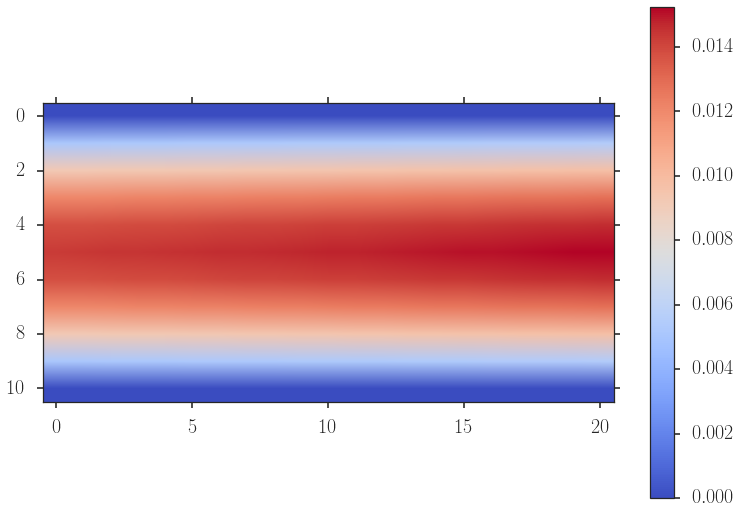

In [36]:
fields = sim0.get_fields()
plt.imshow(fields['u'].T, cmap=cm.coolwarm)
plt.grid(False)

plt.colorbar()

RUH ROH lol

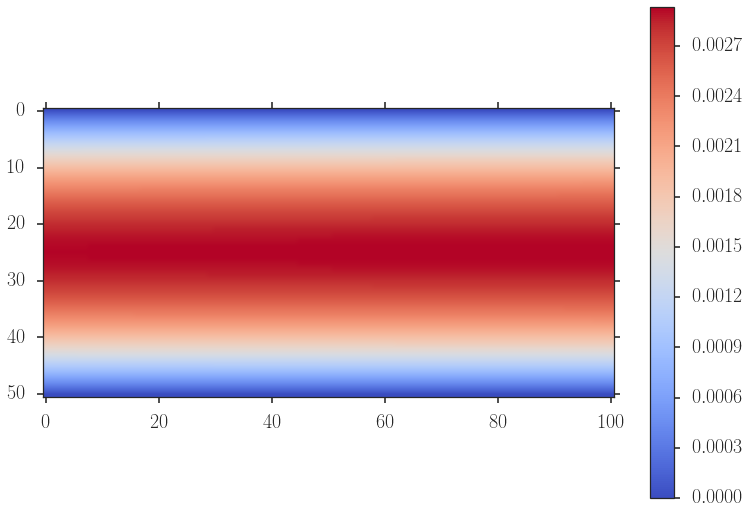

In [67]:
fields = sim1.get_fields()
plt.imshow(fields['u'].T, cmap=cm.coolwarm)
plt.grid(False)

plt.colorbar()

RUH ROH LOLOLOLOLOLOL

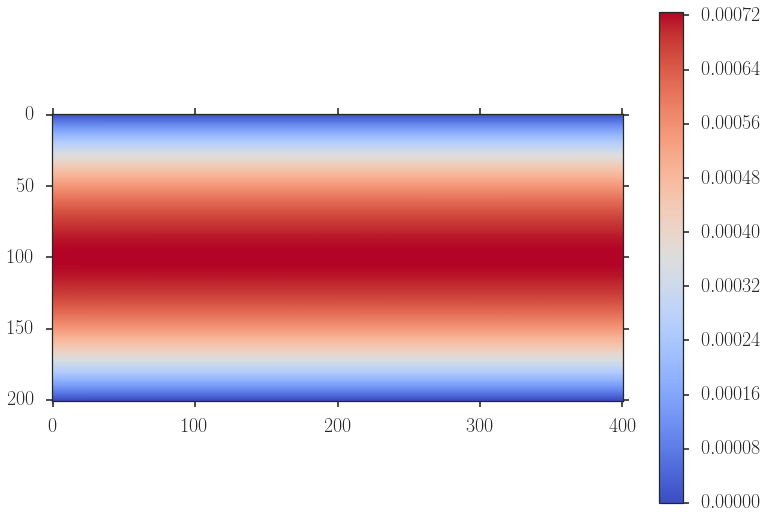

In [38]:
fields = sim2.get_fields()
plt.imshow(fields['u'].T, cmap=cm.coolwarm)
plt.grid(False)

plt.colorbar()

This still looks super wacky. Not sure why...

We make a plot of our pipe flow solution. sim2 is the highest resolution and consequently looks the best!

In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

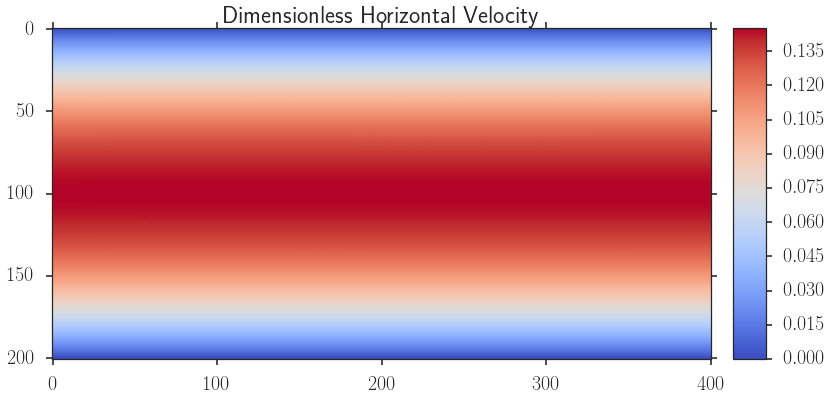

In [40]:
fields = sim2.get_nondim_fields()
im = plt.imshow(fields['u'].T, cmap=cm.coolwarm)
plt.grid(False)
plt.title('Dimensionless Horizontal Velocity')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.3)
plt.colorbar(im, cax=cax)

plt.savefig('standard_pipe_flow.png', dpi=200, bbox_inches='tight')

In [41]:
sns.set_style('ticks')

In [42]:
import matplotlib

In [43]:
matplotlib.rc('text', usetex=True)

We now compare our simulations with theory.

Yeah. Our Bc on the wall doesn't look right...negative velocity on the wall? lol

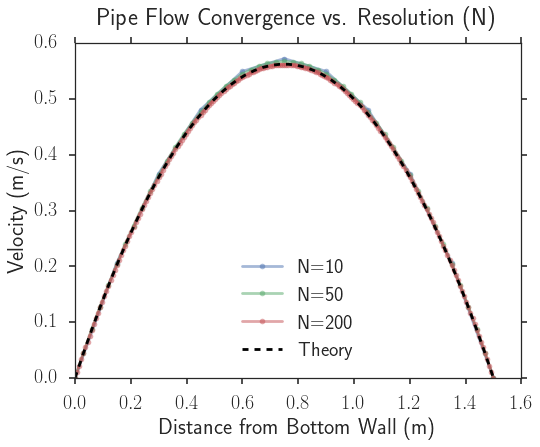

In [68]:
fields0 = sim0.get_physical_fields()
fields1 = sim1.get_physical_fields()
fields2 = sim2.get_physical_fields()

x_values = np.arange(fields0['u'].T.shape[0])*sim0.delta_x*sim0.L
# Get the mean velocity in the x direction
mean_u = fields0['u'].T.mean(axis=1)
plt.plot(x_values, mean_u, label='N=10', ls='-', marker='.', alpha=0.5)


x_values = np.arange(fields1['u'].T.shape[0])*sim1.delta_x*sim1.L
# Get the mean velocity in the x direction
mean_u = fields1['u'].T.mean(axis=1)
plt.plot(x_values, mean_u, label='N=50', ls='-', marker='.', alpha=0.5)

x_values = np.arange(fields2['u'].T.shape[0])*sim2.delta_x*sim2.L
mean_u = fields2['u'].T.mean(axis=1)
plt.plot(x_values, mean_u, label='N=200', ls='-', marker='.', alpha=0.5)

prefactor = (1./(2*rho*nu))*pressure_grad
y = np.linspace(0, D)

predicted = prefactor*y*(y-D)
# Convert non-dim predicted

plt.plot(y, predicted, label='Theory', color='Black', ls='--')

plt.xlabel('Distance from Bottom Wall (m)')
plt.ylabel('Velocity (m/s)')

plt.title('Pipe Flow Convergence vs. Resolution (N)', y=1.04)

plt.legend(loc='best')

plt.gcf().set_size_inches(8, 6)

plt.ylim(0, .6)

plt.savefig('resolution_convergence.png', dpi=200, bbox_inches='tight')

Beautiful. Can we plot the average error vs N?

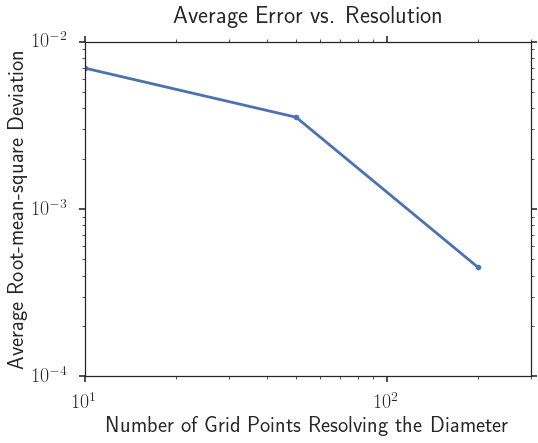

In [72]:
# Predicted
prefactor = (1./(2*rho*nu))*pressure_grad
y = np.linspace(0, D)
predicted = prefactor*y*(y-D)

# Compare the error
fields0 = sim0.get_physical_fields()
fields1 = sim1.get_physical_fields()
fields2 = sim2.get_physical_fields()

x_values = np.arange(fields0['u'].T.shape[0])*sim0.delta_x*sim0.L
# Get the mean velocity in the x direction
mean_u = fields0['u'].T.mean(axis=1)
error1 = (mean_u - prefactor*x_values*(x_values - D))**2
error1 = np.sqrt(error1.mean())

x_values = np.arange(fields1['u'].T.shape[0])*sim1.delta_x*sim1.L
# Get the mean velocity in the x direction
mean_u = fields1['u'].T.mean(axis=1)
error2 = (mean_u - prefactor*x_values*(x_values - D))**2
error2 = np.sqrt(error2.mean())

x_values = np.arange(fields2['u'].T.shape[0])*sim2.delta_x*sim2.L
mean_u = fields2['u'].T.mean(axis=1)
error3 = (mean_u - prefactor*x_values*(x_values - D))**2
error3 = np.sqrt(error3.mean())

plt.loglog([10, 50, 200], [error1, error2, error3], ls='-', marker='.')

#plt.loglog(y, predicted, label='Theory', color='Black', ls='--')

plt.xlabel('Number of Grid Points Resolving the Diameter')
plt.ylabel('Average Root-mean-square Deviation')

plt.title('Average Error vs. Resolution', y=1.04)

plt.legend(loc='best')

plt.gcf().set_size_inches(8, 6)

plt.xlim(10, 300)

plt.savefig('pipe_flow_converge.png', dpi=200, bbox_inches='tight')